# NLP Binary classification with 

Notebook to prepare the tensorflow Certified Developer. 

Binary Text Classification. 

Dataset from: 
https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv



## Import libraries

In [1]:
#First steep is import the libraries. 
import tensorflow as tf
tf.random.set_seed(42)
#Numpy is a lybrary that allow us to work with arrays. 
import numpy as np
#keras is an open source neural networks lybrary writted in python that run's in varios frameworks, TensorFlow included. 
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import csv

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.stats import linregress

#Tranfer learning from tensorhub
import tensorflow_hub as hub

print (tf.__version__)

gEpochs = 10

2.9.0


# Functions


In [2]:
#clear the text 
import re
def cleanText(text):
    whitespace = re.compile(r"\s+")
    web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = web_address.sub('', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]", "", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    return text.lower()

In [54]:
def get_model(kindmodel):
    switcher = {
        #FLATTEN
        #2s 10ms/step - loss: 0.0200 - accuracy: 0.9937 - val_loss: 0.6146 - val_accuracy: 0.7648
        0:tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(6, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')]), 
        #GLOBALAVERAGE
        #2s 11ms/step - loss: 0.0534 - accuracy: 0.9839 - val_loss: 0.6842 - val_accuracy: 0.7411
        1:tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
            tf.keras.layers.GlobalAveragePooling1D(), 
            tf.keras.layers.Dense(6, activation='relu'), 
            tf.keras.layers.Dense(1, activation='sigmoid')]),
        #GlobalAverage + ExtraDense + Dropout
        #2s 11ms/step - loss: 0.1676 - accuracy: 0.9472 - val_loss: 0.7998 - val_accuracy: 0.7385
        11:tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
            tf.keras.layers.GlobalAveragePooling1D(), 
            tf.keras.layers.Dense(6, activation='relu'), 
            tf.keras.layers.Dense(6, activation='relu'),
            tf.keras.layers.Dropout(0.4), 
            tf.keras.layers.Dense(1, activation='sigmoid')]),
        #LSTM Simple
        #6s 26ms/step - loss: 0.0272 - accuracy: 0.9898 - val_loss: 1.0936 - val_accuracy: 0.6873
        2:tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
            tf.keras.layers.Dense(6, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')]), 
        #LSTM Multiple with return
        #10s 46ms/step - loss: 0.0283 - accuracy: 0.9902 - val_loss: 0.9955 - val_accuracy: 0.7280
        3:tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
            tf.keras.layers.Dense(6, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')]),
        #LSTM Multiple with Dropouts
        #10s 48ms/step - loss: 0.0485 - accuracy: 0.9774 - val_loss: 0.9943 - val_accuracy: 0.7096
        31:tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim), 
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(6, activation='relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(1, activation='sigmoid')]),
        #Convolutional GlobalMaxPooling
        #2s 11ms/step - loss: 0.0217 - accuracy: 0.9927 - val_loss: 0.7766 - val_accuracy: 0.7556
        4:tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
            tf.keras.layers.Conv1D(64, kernel_size=5, activation='relu'),
            tf.keras.layers.GlobalMaxPooling1D(),
            tf.keras.layers.Dense(6, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')]),
        #Convolutional GlovalAveragePooling & Dropout
        #3s 12ms/step - loss: 0.0739 - accuracy: 0.9739 - val_loss: 1.2099 - val_accuracy: 0.7083
        5:tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
            tf.keras.layers.Conv1D(32, kernel_size=5, activation='relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(6, activation='relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(1, activation='sigmoid')]), 
        #SpatialDropout after Emebedding and dropout inside LSTM
        #14s 67ms/step - loss: 0.2182 - accuracy: 0.9174 - val_loss: 0.5407 - val_accuracy: 0.7727
        6:tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
            tf.keras.layers.SpatialDropout1D(0.4),
            #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout = 0.8, recurrent_dropout=0.8, return_sequences=True)),
            #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,dropout = 0.5,recurrent_dropout=0.5,return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout = 0.8, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout = 0.5, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.GRU(8,return_sequences=False)),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(1, activation='sigmoid')]),   
    }
    return switcher.get(kindmodel, None)

In [4]:

def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo-', label='Training accuracy')
  plt.plot(epochs, val_acc, 'go-', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo-', label='Training Loss')
  plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [5]:
#Get the data from the .csv without pandas. 
def parse_data(filename, xpos, ypos,  omitheaders=True, delimiter=',', returnlabels=True):
    tweets = []
    labels = []
    
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=delimiter)
        if omitheaders:
            csvfile.readline()
        for line in reader:
            tweets.append(cleanText(line[xpos]))
            if returnlabels:
                labels.append(int(line[ypos]))
    
    return tweets, labels


In [6]:
#split the data in tarning / validate data 
def split_data(data, label, validation=10):
    validsize = int(len(data) * (validation / 100))
    total_length = len(data)
    v_data = data[0:validsize]
    t_data = data[validsize:]
    
    v_label = label[0:validsize]
    t_label = label[validsize:]
    
    return  t_data, t_label, v_data, v_label

### prepare the data for the model

In [7]:
traindatafile = "./Data/traindisaster.csv"
testdatafile = "./Data/testdisaster.csv"

In [8]:
with open(traindatafile, 'r') as train_df:
    print (train_df.readline())
    print (train_df.readline())

id,keyword,location,text,target

1,,,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1



In [9]:
with open(testdatafile, 'r') as test_df:
    print (test_df.readline())
    print (test_df.readline())

id,keyword,location,text

0,,,Just happened a terrible car crash



In [10]:
x_traindata, y_traindata = parse_data(traindatafile, 3, 4)
print(x_traindata[0])
print(len(x_traindata))
print(y_traindata[0])



our deeds are the reason of this earthquake may allah forgive us all
7613
1


In [11]:
x_test, y_test = parse_data(testdatafile, 3, 0, returnlabels=False)

In [12]:
x_train, y_train, x_val, y_val=split_data(x_traindata, y_traindata, validation =10)
print (len(x_train))
print (len(y_train))
print (len(x_val))
print (len(y_val))
print (x_train[0])
print (x_val[0])

6852
6852
761
761
just realized my dude  was on that what are those way before it blew up  the tusky  game  
our deeds are the reason of this earthquake may allah forgive us all


In [13]:
# Parameters for padding and OOV tokens
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

vocab_size = 18000
max_length  = max([len(s.split()) for s in x_train])
print (max_length)

# Hyperparameters
embedding_dim = 64
lstm_dim = 64




31


In [14]:
# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
print(f'number of words in word_index: {len(word_index)}')

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(x_train)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
validation_sequences = tokenizer.texts_to_sequences(x_val)
validation_padded = pad_sequences(validation_sequences, 
                               maxlen=max_length, truncating=trunc_type)

y_train = np.array(y_train)
y_val = np.array(y_val)

number of words in word_index: 17835


# Flatten



In [15]:
model0 = get_model(0)

# Setup the training parameters
model0.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model0.summary()

Metal device set to: Apple M1 Pro


2022-07-31 19:21:16.812820: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-31 19:21:16.813229: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 31, 64)            1152000   
                                                                 
 flatten (Flatten)           (None, 1984)              0         
                                                                 
 dense (Dense)               (None, 6)                 11910     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 1,163,917
Trainable params: 1,163,917
Non-trainable params: 0
_________________________________________________________________


In [16]:
history0 = model0.fit(padded, y_train, epochs=gEpochs, 
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-31 19:21:18.875792: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  1/215 [..............................] - ETA: 1:16 - loss: 0.6920 - accuracy: 0.6250

2022-07-31 19:21:19.087256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 3s 13ms/step - loss: 0.6374 - accuracy: 0.6306 - val_loss: 0.5515 - val_accuracy: 0.7477
Epoch 2/10
  1/215 [..............................] - ETA: 2s - loss: 0.5192 - accuracy: 0.7812

2022-07-31 19:21:21.821284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 2s 10ms/step - loss: 0.3612 - accuracy: 0.8716 - val_loss: 0.4776 - val_accuracy: 0.7884
Epoch 3/10
215/215 [==============================] - 2s 10ms/step - loss: 0.1154 - accuracy: 0.9669 - val_loss: 0.4912 - val_accuracy: 0.7819
Epoch 4/10
215/215 [==============================] - 2s 10ms/step - loss: 0.0483 - accuracy: 0.9853 - val_loss: 0.5197 - val_accuracy: 0.7753
Epoch 5/10
215/215 [==============================] - 2s 10ms/step - loss: 0.0344 - accuracy: 0.9898 - val_loss: 0.5571 - val_accuracy: 0.7569
Epoch 6/10
215/215 [==============================] - 2s 11ms/step - loss: 0.0254 - accuracy: 0.9931 - val_loss: 0.5663 - val_accuracy: 0.7582
Epoch 7/10
215/215 [==============================] - 2s 11ms/step - loss: 0.0239 - accuracy: 0.9934 - val_loss: 0.5785 - val_accuracy: 0.7648
Epoch 8/10
215/215 [==============================] - 2s 11ms/step - loss: 0.0217 - accuracy: 0.9934 - val_loss: 0.5826 - val_accuracy: 0.7740
Epoch 9/10

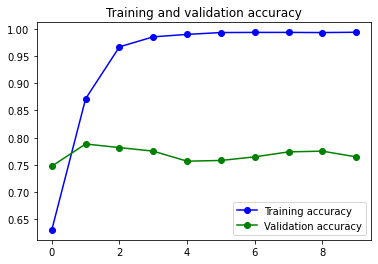

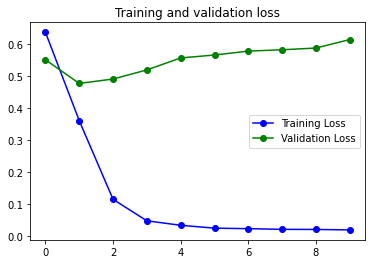

In [17]:
plot_loss_acc(history0)

## model 1 GlobalAverage


In [18]:
model1 = get_model(1)

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 31, 64)            1152000   
                                                                 
 global_average_pooling1d_3   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_20 (Dense)            (None, 6)                 390       
                                                                 
 dense_21 (Dense)            (None, 1)                 7         
                                                                 
Total params: 1,152,397
Trainable params: 1,152,397
Non-trainable params: 0
_________________________________________________________________


In [19]:
history1 = model1.fit(padded, y_train, epochs=gEpochs, 
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-31 19:21:43.986561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 3s 13ms/step - loss: 0.6546 - accuracy: 0.6052 - val_loss: 0.5733 - val_accuracy: 0.7240
Epoch 2/10
  1/215 [..............................] - ETA: 2s - loss: 0.5814 - accuracy: 0.6875

2022-07-31 19:21:46.830053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 2s 11ms/step - loss: 0.4650 - accuracy: 0.8192 - val_loss: 0.4763 - val_accuracy: 0.7845
Epoch 3/10
215/215 [==============================] - 2s 10ms/step - loss: 0.3263 - accuracy: 0.8749 - val_loss: 0.4575 - val_accuracy: 0.7884
Epoch 4/10
215/215 [==============================] - 2s 10ms/step - loss: 0.2411 - accuracy: 0.9123 - val_loss: 0.4672 - val_accuracy: 0.7884
Epoch 5/10
215/215 [==============================] - 2s 10ms/step - loss: 0.1782 - accuracy: 0.9383 - val_loss: 0.5030 - val_accuracy: 0.7661
Epoch 6/10
215/215 [==============================] - 2s 10ms/step - loss: 0.1346 - accuracy: 0.9569 - val_loss: 0.5303 - val_accuracy: 0.7595
Epoch 7/10
215/215 [==============================] - 2s 10ms/step - loss: 0.1013 - accuracy: 0.9682 - val_loss: 0.5628 - val_accuracy: 0.7622
Epoch 8/10
215/215 [==============================] - 2s 10ms/step - loss: 0.0801 - accuracy: 0.9769 - val_loss: 0.6012 - val_accuracy: 0.7674
Epoch 9/10

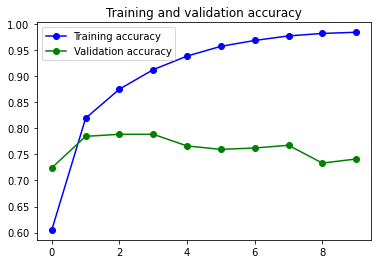

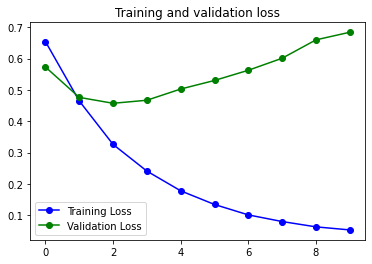

In [20]:
plot_loss_acc(history1)

In [21]:
model11 = get_model(11)

# Setup the training parameters
model11.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model11.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 31, 64)            1152000   
                                                                 
 global_average_pooling1d_7   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_40 (Dense)            (None, 6)                 390       
                                                                 
 dense_41 (Dense)            (None, 6)                 42        
                                                                 
 dropout_12 (Dropout)        (None, 6)                 0         
                                                                 
 dense_42 (Dense)            (None, 1)                 7         
                                                     

In [22]:
history111 = model11.fit(padded, y_train, epochs=gEpochs, 
          validation_data=(validation_padded, y_val))

Epoch 1/10
  1/215 [..............................] - ETA: 1:46 - loss: 0.6839 - accuracy: 0.6562

2022-07-31 19:22:09.092260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 4s 14ms/step - loss: 0.6624 - accuracy: 0.5976 - val_loss: 0.5853 - val_accuracy: 0.7293
Epoch 2/10


2022-07-31 19:22:12.087727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 3s 12ms/step - loss: 0.5424 - accuracy: 0.7480 - val_loss: 0.4996 - val_accuracy: 0.7898
Epoch 3/10
215/215 [==============================] - 2s 11ms/step - loss: 0.4199 - accuracy: 0.8475 - val_loss: 0.4934 - val_accuracy: 0.7832
Epoch 4/10
215/215 [==============================] - 2s 11ms/step - loss: 0.3435 - accuracy: 0.8847 - val_loss: 0.4978 - val_accuracy: 0.7661
Epoch 5/10
215/215 [==============================] - 2s 11ms/step - loss: 0.2797 - accuracy: 0.9120 - val_loss: 0.5293 - val_accuracy: 0.7582
Epoch 6/10
215/215 [==============================] - 2s 11ms/step - loss: 0.2390 - accuracy: 0.9294 - val_loss: 0.5912 - val_accuracy: 0.7254
Epoch 7/10
215/215 [==============================] - 2s 11ms/step - loss: 0.2099 - accuracy: 0.9393 - val_loss: 0.6411 - val_accuracy: 0.7148
Epoch 8/10
215/215 [==============================] - 2s 11ms/step - loss: 0.1929 - accuracy: 0.9451 - val_loss: 0.6919 - val_accuracy: 0.7648
Epoch 9/10

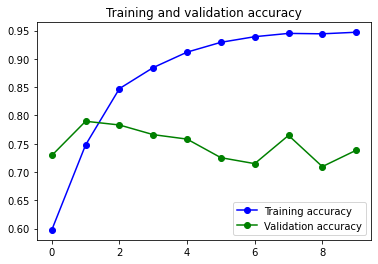

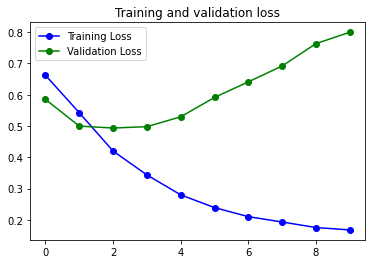

In [23]:
plot_loss_acc(history111)

## Single Layer LSTM

In [24]:

# Build the model
model2 = get_model(2)

# Print the model summary
model2.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, None, 64)          1152000   
                                                                 
 bidirectional_24 (Bidirecti  (None, 128)              66048     
 onal)                                                           
                                                                 
 dense_61 (Dense)            (None, 6)                 774       
                                                                 
 dense_62 (Dense)            (None, 1)                 7         
                                                                 
Total params: 1,218,829
Trainable params: 1,218,829
Non-trainable params: 0
_________________________________________________________________


In [25]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
history2 = model2.fit(padded, y_train, epochs=gEpochs, 
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-31 19:22:37.301503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:22:37.532965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:22:37.543532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:22:37.741235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:22:37.756727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - ETA: 0s - loss: 0.5516 - accuracy: 0.7138

2022-07-31 19:22:44.535973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:22:44.622703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:22:44.631914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 9s 33ms/step - loss: 0.5516 - accuracy: 0.7138 - val_loss: 0.4756 - val_accuracy: 0.7740
Epoch 2/10
215/215 [==============================] - 6s 27ms/step - loss: 0.3101 - accuracy: 0.8797 - val_loss: 0.4879 - val_accuracy: 0.7700
Epoch 3/10
215/215 [==============================] - 6s 27ms/step - loss: 0.1668 - accuracy: 0.9440 - val_loss: 0.6991 - val_accuracy: 0.6938
Epoch 4/10
215/215 [==============================] - 6s 27ms/step - loss: 0.1107 - accuracy: 0.9667 - val_loss: 0.8233 - val_accuracy: 0.7319
Epoch 5/10
215/215 [==============================] - 6s 27ms/step - loss: 0.0743 - accuracy: 0.9787 - val_loss: 0.9956 - val_accuracy: 0.7240
Epoch 6/10
215/215 [==============================] - 6s 27ms/step - loss: 0.0672 - accuracy: 0.9820 - val_loss: 1.0633 - val_accuracy: 0.7214
Epoch 7/10
215/215 [==============================] - 6s 27ms/step - loss: 0.0470 - accuracy: 0.9864 - val_loss: 0.7226 - val_accuracy: 0.7162
Epoch 8/10

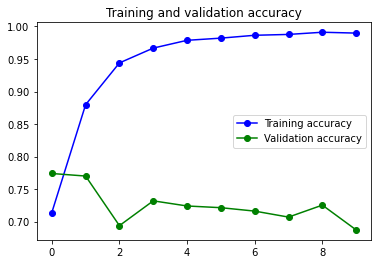

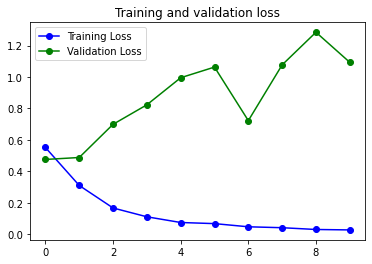

In [27]:
plot_loss_acc(history2)

# Multiple LSTM

In [28]:
# Build the model
model3 = get_model(3)
# Print the model summary
model3.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, None, 64)          1152000   
                                                                 
 bidirectional_33 (Bidirecti  (None, None, 128)        66048     
 onal)                                                           
                                                                 
 bidirectional_34 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_81 (Dense)            (None, 6)                 390       
                                                                 
 dense_82 (Dense)            (None, 1)                 7         
                                                                 
Total params: 1,259,661
Trainable params: 1,259,661
N

In [29]:
# Set the training parameters
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
history3 = model3.fit(padded, y_train, epochs=gEpochs, 
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-31 19:23:41.359556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:23:41.749077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:23:41.759410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:23:41.850960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:23:41.861072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:23:42.007896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:23:42.023177: I tensorflow/core/grappler/optimizers/cust

215/215 [==============================] - ETA: 0s - loss: 0.5341 - accuracy: 0.7283

2022-07-31 19:23:53.382829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:23:53.520209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:23:53.527171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:23:53.605156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:23:53.612603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 15s 57ms/step - loss: 0.5341 - accuracy: 0.7283 - val_loss: 0.4727 - val_accuracy: 0.7858
Epoch 2/10
215/215 [==============================] - 10s 48ms/step - loss: 0.2859 - accuracy: 0.8900 - val_loss: 0.4828 - val_accuracy: 0.7832
Epoch 3/10
215/215 [==============================] - 10s 47ms/step - loss: 0.1442 - accuracy: 0.9501 - val_loss: 0.5546 - val_accuracy: 0.7477
Epoch 4/10
215/215 [==============================] - 10s 48ms/step - loss: 0.0876 - accuracy: 0.9721 - val_loss: 0.6940 - val_accuracy: 0.7516
Epoch 5/10
215/215 [==============================] - 10s 46ms/step - loss: 0.0578 - accuracy: 0.9822 - val_loss: 0.7660 - val_accuracy: 0.7398
Epoch 6/10
215/215 [==============================] - 10s 47ms/step - loss: 0.0417 - accuracy: 0.9877 - val_loss: 1.0069 - val_accuracy: 0.7267
Epoch 7/10
215/215 [==============================] - 10s 47ms/step - loss: 0.0317 - accuracy: 0.9901 - val_loss: 0.9755 - val_accuracy: 0.7227
Epo

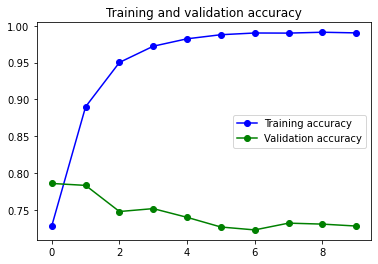

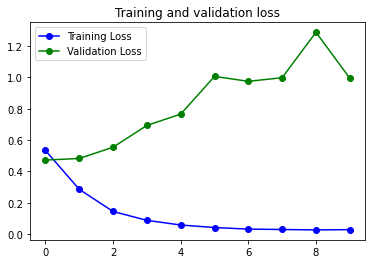

In [31]:
plot_loss_acc(history3)

In [32]:
# Build the model
model31 = get_model(31)
# Print the model summary
model31.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_50 (Embedding)    (None, None, 64)          1152000   
                                                                 
 bidirectional_43 (Bidirecti  (None, None, 128)        66048     
 onal)                                                           
                                                                 
 bidirectional_44 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dropout_31 (Dropout)        (None, 64)                0         
                                                                 
 dense_101 (Dense)           (None, 6)                 390       
                                                                 
 dropout_32 (Dropout)        (None, 6)               

In [33]:
# Set the training parameters
model31.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
history31 = model31.fit(padded, y_train, epochs=gEpochs, 
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-31 19:25:29.512391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:25:29.894034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:25:29.905790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:25:30.009808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:25:30.020245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:25:30.287194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:25:30.302610: I tensorflow/core/grappler/optimizers/cust

215/215 [==============================] - ETA: 0s - loss: 0.5804 - accuracy: 0.6919

2022-07-31 19:25:42.214986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:25:42.358001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:25:42.365178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:25:42.467877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:25:42.475784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 16s 59ms/step - loss: 0.5804 - accuracy: 0.6919 - val_loss: 0.4810 - val_accuracy: 0.7950
Epoch 2/10
215/215 [==============================] - 10s 48ms/step - loss: 0.3480 - accuracy: 0.8615 - val_loss: 0.4829 - val_accuracy: 0.7792
Epoch 3/10
215/215 [==============================] - 10s 48ms/step - loss: 0.2003 - accuracy: 0.9235 - val_loss: 0.5489 - val_accuracy: 0.7556
Epoch 4/10
215/215 [==============================] - 10s 49ms/step - loss: 0.1334 - accuracy: 0.9515 - val_loss: 0.5844 - val_accuracy: 0.7595
Epoch 5/10
215/215 [==============================] - 10s 47ms/step - loss: 0.0881 - accuracy: 0.9673 - val_loss: 0.7909 - val_accuracy: 0.7135
Epoch 6/10
215/215 [==============================] - 10s 47ms/step - loss: 0.0746 - accuracy: 0.9720 - val_loss: 0.7641 - val_accuracy: 0.7096
Epoch 7/10
215/215 [==============================] - 10s 48ms/step - loss: 0.0599 - accuracy: 0.9753 - val_loss: 0.7640 - val_accuracy: 0.7293
Epo

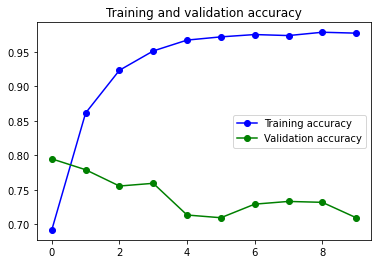

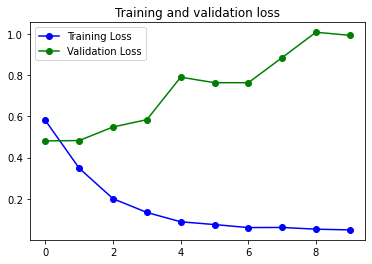

In [35]:
plot_loss_acc(history31)

# Convolutional Model

In [36]:
# Build the model
model4 = get_model(4)
# Print the model summary
model4.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_60 (Embedding)    (None, 31, 64)            1152000   
                                                                 
 conv1d_12 (Conv1D)          (None, 27, 64)            20544     
                                                                 
 global_max_pooling1d_6 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_121 (Dense)           (None, 6)                 390       
                                                                 
 dense_122 (Dense)           (None, 1)                 7         
                                                                 
Total params: 1,172,941
Trainable params: 1,172,941
Non-trainable params: 0
___________________________________________

In [37]:
# Set the training parameters
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history4 = model4.fit(padded, y_train, epochs=gEpochs, 
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-31 19:27:17.672768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - ETA: 0s - loss: 0.5870 - accuracy: 0.6687

2022-07-31 19:27:20.883839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 4s 15ms/step - loss: 0.5870 - accuracy: 0.6687 - val_loss: 0.4650 - val_accuracy: 0.7740
Epoch 2/10
215/215 [==============================] - 2s 11ms/step - loss: 0.3239 - accuracy: 0.8691 - val_loss: 0.4480 - val_accuracy: 0.7871
Epoch 3/10
215/215 [==============================] - 2s 11ms/step - loss: 0.1636 - accuracy: 0.9432 - val_loss: 0.5127 - val_accuracy: 0.7806
Epoch 4/10
215/215 [==============================] - 2s 11ms/step - loss: 0.0804 - accuracy: 0.9745 - val_loss: 0.6216 - val_accuracy: 0.7582
Epoch 5/10
215/215 [==============================] - 2s 11ms/step - loss: 0.0491 - accuracy: 0.9844 - val_loss: 0.6707 - val_accuracy: 0.7569
Epoch 6/10
215/215 [==============================] - 2s 11ms/step - loss: 0.0344 - accuracy: 0.9896 - val_loss: 0.7036 - val_accuracy: 0.7635
Epoch 7/10
215/215 [==============================] - 2s 11ms/step - loss: 0.0298 - accuracy: 0.9908 - val_loss: 0.7747 - val_accuracy: 0.7779
Epoch 8/10

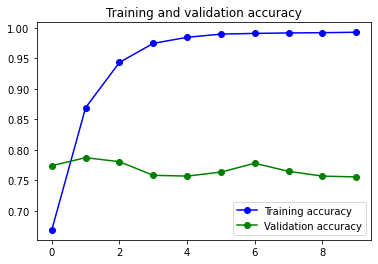

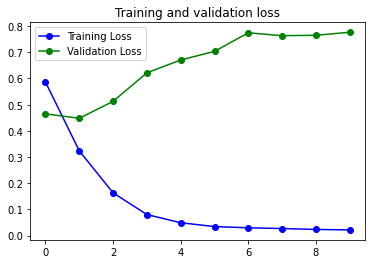

In [38]:
plot_loss_acc(history4)

In [39]:
# Build the model
model5 = get_model(5)
# Print the model summary
model5.summary()

Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_70 (Embedding)    (None, 31, 64)            1152000   
                                                                 
 conv1d_15 (Conv1D)          (None, 27, 32)            10272     
                                                                 
 dropout_45 (Dropout)        (None, 27, 32)            0         
                                                                 
 global_average_pooling1d_23  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_141 (Dense)           (None, 6)                 198       
                                                                 
 dropout_46 (Dropout)        (None, 6)                 0         
                                                     

In [40]:
# Set the training parameters
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history5 = model5.fit(padded, y_train, epochs=gEpochs, 
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-31 19:27:44.870046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - ETA: 0s - loss: 0.6239 - accuracy: 0.6414

2022-07-31 19:27:48.539736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 4s 16ms/step - loss: 0.6239 - accuracy: 0.6414 - val_loss: 0.5042 - val_accuracy: 0.7806
Epoch 2/10
215/215 [==============================] - 3s 12ms/step - loss: 0.4105 - accuracy: 0.8316 - val_loss: 0.4803 - val_accuracy: 0.7714
Epoch 3/10
215/215 [==============================] - 3s 12ms/step - loss: 0.2799 - accuracy: 0.9002 - val_loss: 0.5398 - val_accuracy: 0.7398
Epoch 4/10
215/215 [==============================] - 3s 12ms/step - loss: 0.2034 - accuracy: 0.9323 - val_loss: 0.6263 - val_accuracy: 0.7359
Epoch 5/10
215/215 [==============================] - 3s 12ms/step - loss: 0.1547 - accuracy: 0.9450 - val_loss: 0.7407 - val_accuracy: 0.7319
Epoch 6/10
215/215 [==============================] - 3s 12ms/step - loss: 0.1229 - accuracy: 0.9571 - val_loss: 0.8409 - val_accuracy: 0.7254
Epoch 7/10
215/215 [==============================] - 3s 12ms/step - loss: 0.0972 - accuracy: 0.9673 - val_loss: 0.9136 - val_accuracy: 0.7240
Epoch 8/10

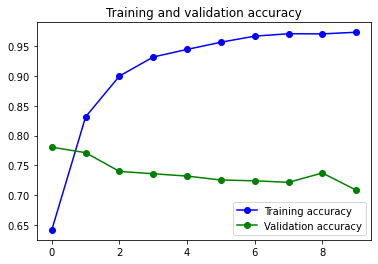

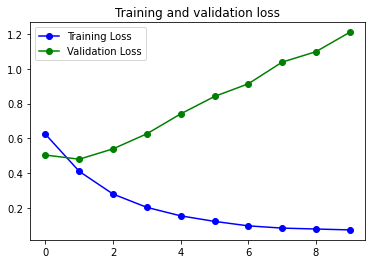

In [41]:
plot_loss_acc(history5)

## Dropout in layer LSTM & Combination layers

In [42]:
# Build the model
model6 = get_model(6)
# Print the model summary
model6.summary()

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_80 (Embedding)    (None, 31, 64)            1152000   
                                                                 
 spatial_dropout1d_8 (Spatia  (None, 31, 64)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_69 (Bidirecti  (None, 31, 128)          66048     
 onal)                                                           
                                                                 
 bidirectional_70 (Bidirecti  (None, 31, 64)           41216     
 onal)                                                           
                                                                 
 bidirectional_71 (Bidirecti  (None, 16)               3552      
 onal)                                               

In [43]:
# Set the training parameters
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history6 = model6.fit(padded, y_train, epochs=gEpochs, 
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-31 19:28:17.441598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:28:18.062965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:28:18.073070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:28:18.214549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:28:18.224656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:28:18.342566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:28:18.351284: I tensorflow/core/grappler/optimizers/cust

215/215 [==============================] - ETA: 0s - loss: 0.6440 - accuracy: 0.6179

2022-07-31 19:28:36.644325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:28:36.839393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:28:36.846400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:28:36.984578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:28:36.991792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:28:37.137761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:28:37.144276: I tensorflow/core/grappler/optimizers/cust

215/215 [==============================] - 24s 88ms/step - loss: 0.6440 - accuracy: 0.6179 - val_loss: 0.5327 - val_accuracy: 0.7582
Epoch 2/10
215/215 [==============================] - 15s 68ms/step - loss: 0.4868 - accuracy: 0.7855 - val_loss: 0.5178 - val_accuracy: 0.7556
Epoch 3/10
215/215 [==============================] - 14s 67ms/step - loss: 0.4043 - accuracy: 0.8319 - val_loss: 0.4995 - val_accuracy: 0.7595
Epoch 4/10
215/215 [==============================] - 14s 67ms/step - loss: 0.3616 - accuracy: 0.8525 - val_loss: 0.4966 - val_accuracy: 0.7884
Epoch 5/10
215/215 [==============================] - 14s 66ms/step - loss: 0.3275 - accuracy: 0.8726 - val_loss: 0.5048 - val_accuracy: 0.7582
Epoch 6/10
215/215 [==============================] - 14s 66ms/step - loss: 0.3089 - accuracy: 0.8806 - val_loss: 0.5001 - val_accuracy: 0.7779
Epoch 7/10
215/215 [==============================] - 15s 67ms/step - loss: 0.2789 - accuracy: 0.8919 - val_loss: 0.4878 - val_accuracy: 0.7753
Epo

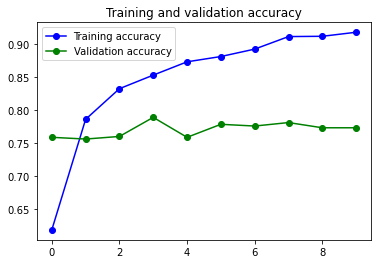

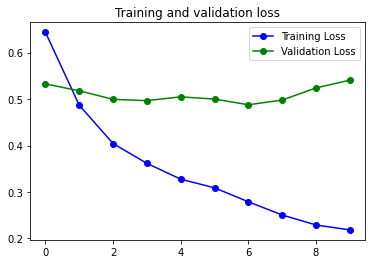

In [44]:
plot_loss_acc(history6)

In [55]:
# Build the model
model61 = get_model(61)
# Print the model summary
model61.summary()

Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_90 (Embedding)    (None, 31, 64)            1152000   
                                                                 
 spatial_dropout1d_10 (Spati  (None, 31, 64)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_80 (Bidirecti  (None, 31, 64)           24832     
 onal)                                                           
                                                                 
 bidirectional_81 (Bidirecti  (None, 31, 32)           10368     
 onal)                                                           
                                                                 
 bidirectional_82 (Bidirecti  (None, 16)               2016      
 onal)                                               

In [57]:
model61.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history61 = model61.fit(padded, y_train, epochs=gEpochs, 
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-31 19:34:24.707933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:34:28.647303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:34:28.658514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:34:29.072428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 19:34:29.087036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  2/215 [..............................] - ETA: 37:49 - loss: 0.6842 - accuracy: 0.6250  

KeyboardInterrupt: 

In [ ]:
plot_loss_acc(history61)

# Transfer learning from TensorHub

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")


2022-07-31 19:31:28.865267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [47]:
train = pd.read_csv(traindatafile)
test = pd.read_csv(testdatafile)

In [48]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [49]:
tweets = train['text']
targets = train['target']

In [50]:
train_tweets , val_tweets , train_targets, val_targets = train_test_split(tweets.to_numpy(), targets.to_numpy(), test_size=0.2)
print(train_tweets[0]) 

Super sweet and beautiful :) https://t.co/TUi9uwBvVp


In [51]:
modeltl0 = tf.keras.Sequential()
modeltl0.add(use_layer)
modeltl0.add(tf.keras.layers.Dense(128,activation='relu'))
modeltl0.add(tf.keras.layers.Dense(1, activation ='sigmoid'))
modeltl0.compile(loss= "binary_crossentropy", optimizer = 'adam',metrics=["accuracy"])
modeltl0.summary()

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_162 (Dense)           (None, 128)               65664     
                                                                 
 dense_163 (Dense)           (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________


In [52]:
historytl0 = modeltl0.fit(train_tweets, train_targets, epochs=gEpochs, 
                          validation_data=(val_tweets, val_targets))

Epoch 1/10


2022-07-31 19:31:31.000622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - ETA: 0s - loss: 0.4908 - accuracy: 0.7906

2022-07-31 19:31:41.817325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - 16s 76ms/step - loss: 0.4908 - accuracy: 0.7906 - val_loss: 0.4460 - val_accuracy: 0.7938
Epoch 2/10
191/191 [==============================] - 9s 49ms/step - loss: 0.4096 - accuracy: 0.8164 - val_loss: 0.4352 - val_accuracy: 0.8076
Epoch 3/10
191/191 [==============================] - 8s 44ms/step - loss: 0.3924 - accuracy: 0.8302 - val_loss: 0.4321 - val_accuracy: 0.8135
Epoch 4/10
191/191 [==============================] - 8s 43ms/step - loss: 0.3827 - accuracy: 0.8343 - val_loss: 0.4305 - val_accuracy: 0.8089
Epoch 5/10
191/191 [==============================] - 8s 43ms/step - loss: 0.3720 - accuracy: 0.8373 - val_loss: 0.4330 - val_accuracy: 0.8083
Epoch 6/10
191/191 [==============================] - 8s 42ms/step - loss: 0.3635 - accuracy: 0.8407 - val_loss: 0.4386 - val_accuracy: 0.8102
Epoch 7/10
191/191 [==============================] - 8s 44ms/step - loss: 0.3542 - accuracy: 0.8442 - val_loss: 0.4341 - val_accuracy: 0.8102
Epoch 8/1

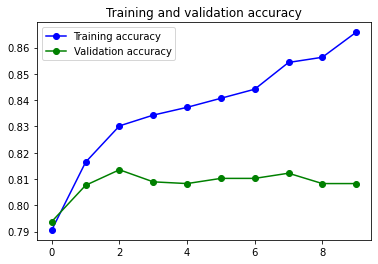

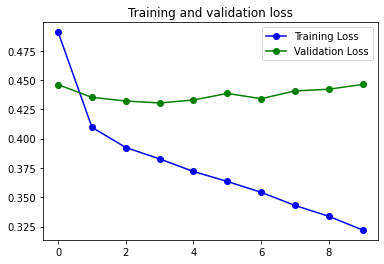

In [53]:
plot_loss_acc(historytl0)